In [1]:
import sys
import os
from os.path import basename
from pathlib import Path
from os.path import join as j

import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import numpy as np

project_root = os.path.abspath('../')

# Segmentation Threshold

### Load Data

In [2]:
import sqlite3
conn_cv = sqlite3.connect(j(project_root,'data','interm','smoothed_cv2_threshold0.2_lengths.sqlite'))

res = conn_cv.execute("SELECT name FROM sqlite_master WHERE type='table';")

print("Tables: %s"%(res.fetchall()))

Tables: [('vein_lengths',)]


In [3]:
conn_man = sqlite3.connect('../reports/data/results.sqlite')

df_data = pd.read_sql("SELECT * FROM vein_lengths",conn_cv)
# df_train = pd.read_sql("SELECT * FROM v3_train_vein_length",conn)
df_human = pd.read_sql("SELECT * FROM manually_measured",conn_man)

In [4]:
R = np.zeros((3,8))
R[:] = np.nan
for i,cv in enumerate(['0','1','2']):
    for k,threshold in enumerate(['0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9']):
        conn_cv = sqlite3.connect(j(project_root,'data','interm','smoothed_cv' + cv + '_threshold' + threshold + '_lengths.sqlite'))
        df_data = pd.read_sql("SELECT * FROM vein_lengths",conn_cv)

        df_data_merged = df_data.merge(df_human[['plant','replicate','length']],
                               on=["plant","replicate"],
                               how="inner",
                               suffixes=("_measured","_human"),
                               validate="one_to_one")

        R[i,k] =  df_data_merged[['length_measured','length_human']].corr()['length_measured'][1]
    



### Plot data

Text(0.5, 0, 'Segmentation Threshold')

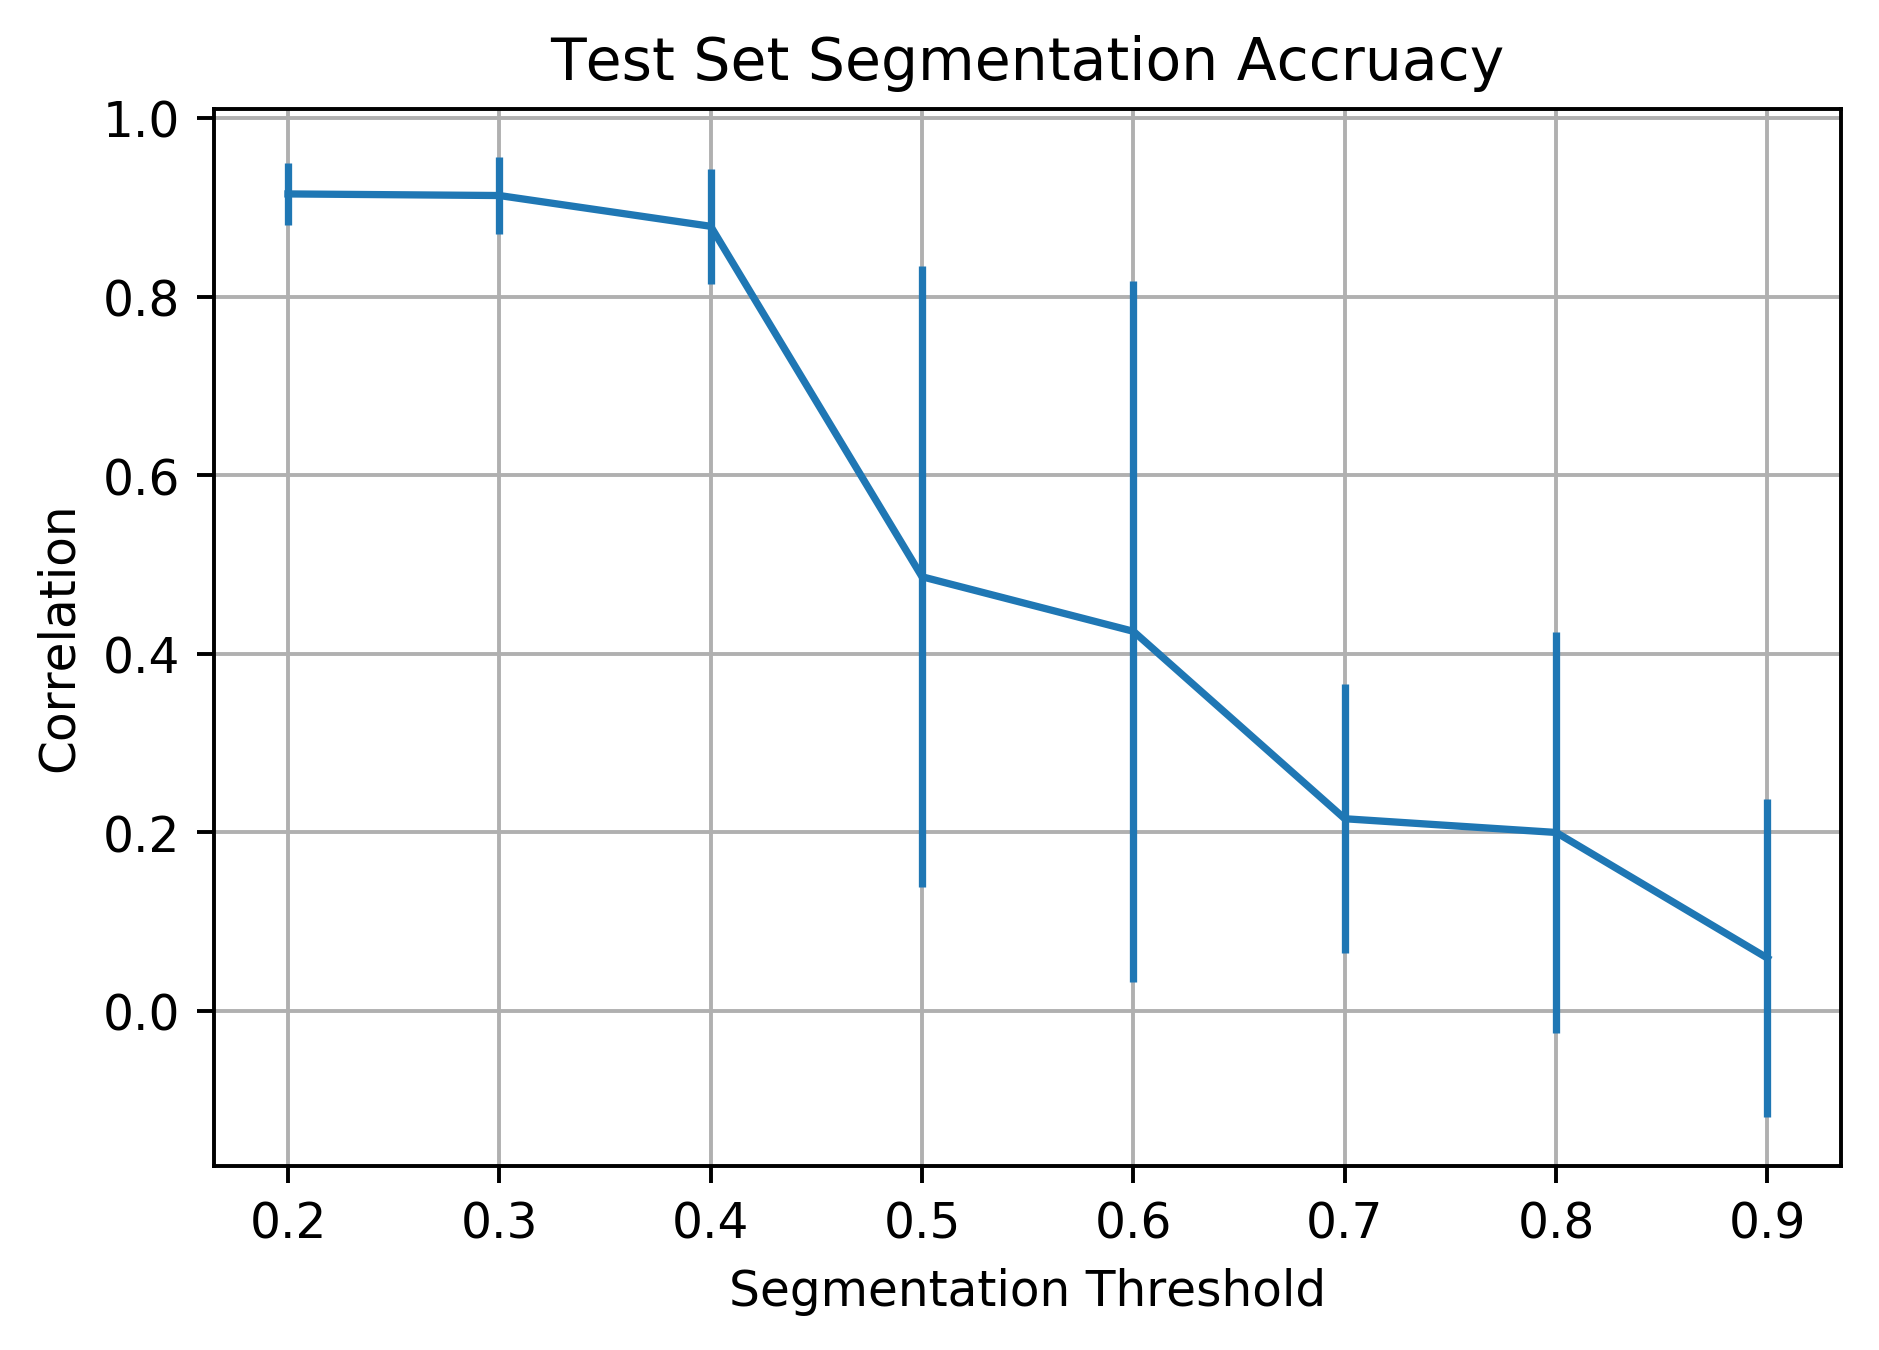

In [5]:
plt.figure(dpi=350)
plt.errorbar([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],R.mean(axis=0),R.std(axis=0))
plt.grid()
plt.title("Test Set Segmentation Accruacy")
plt.ylabel("Correlation")
plt.xlabel("Segmentation Threshold")

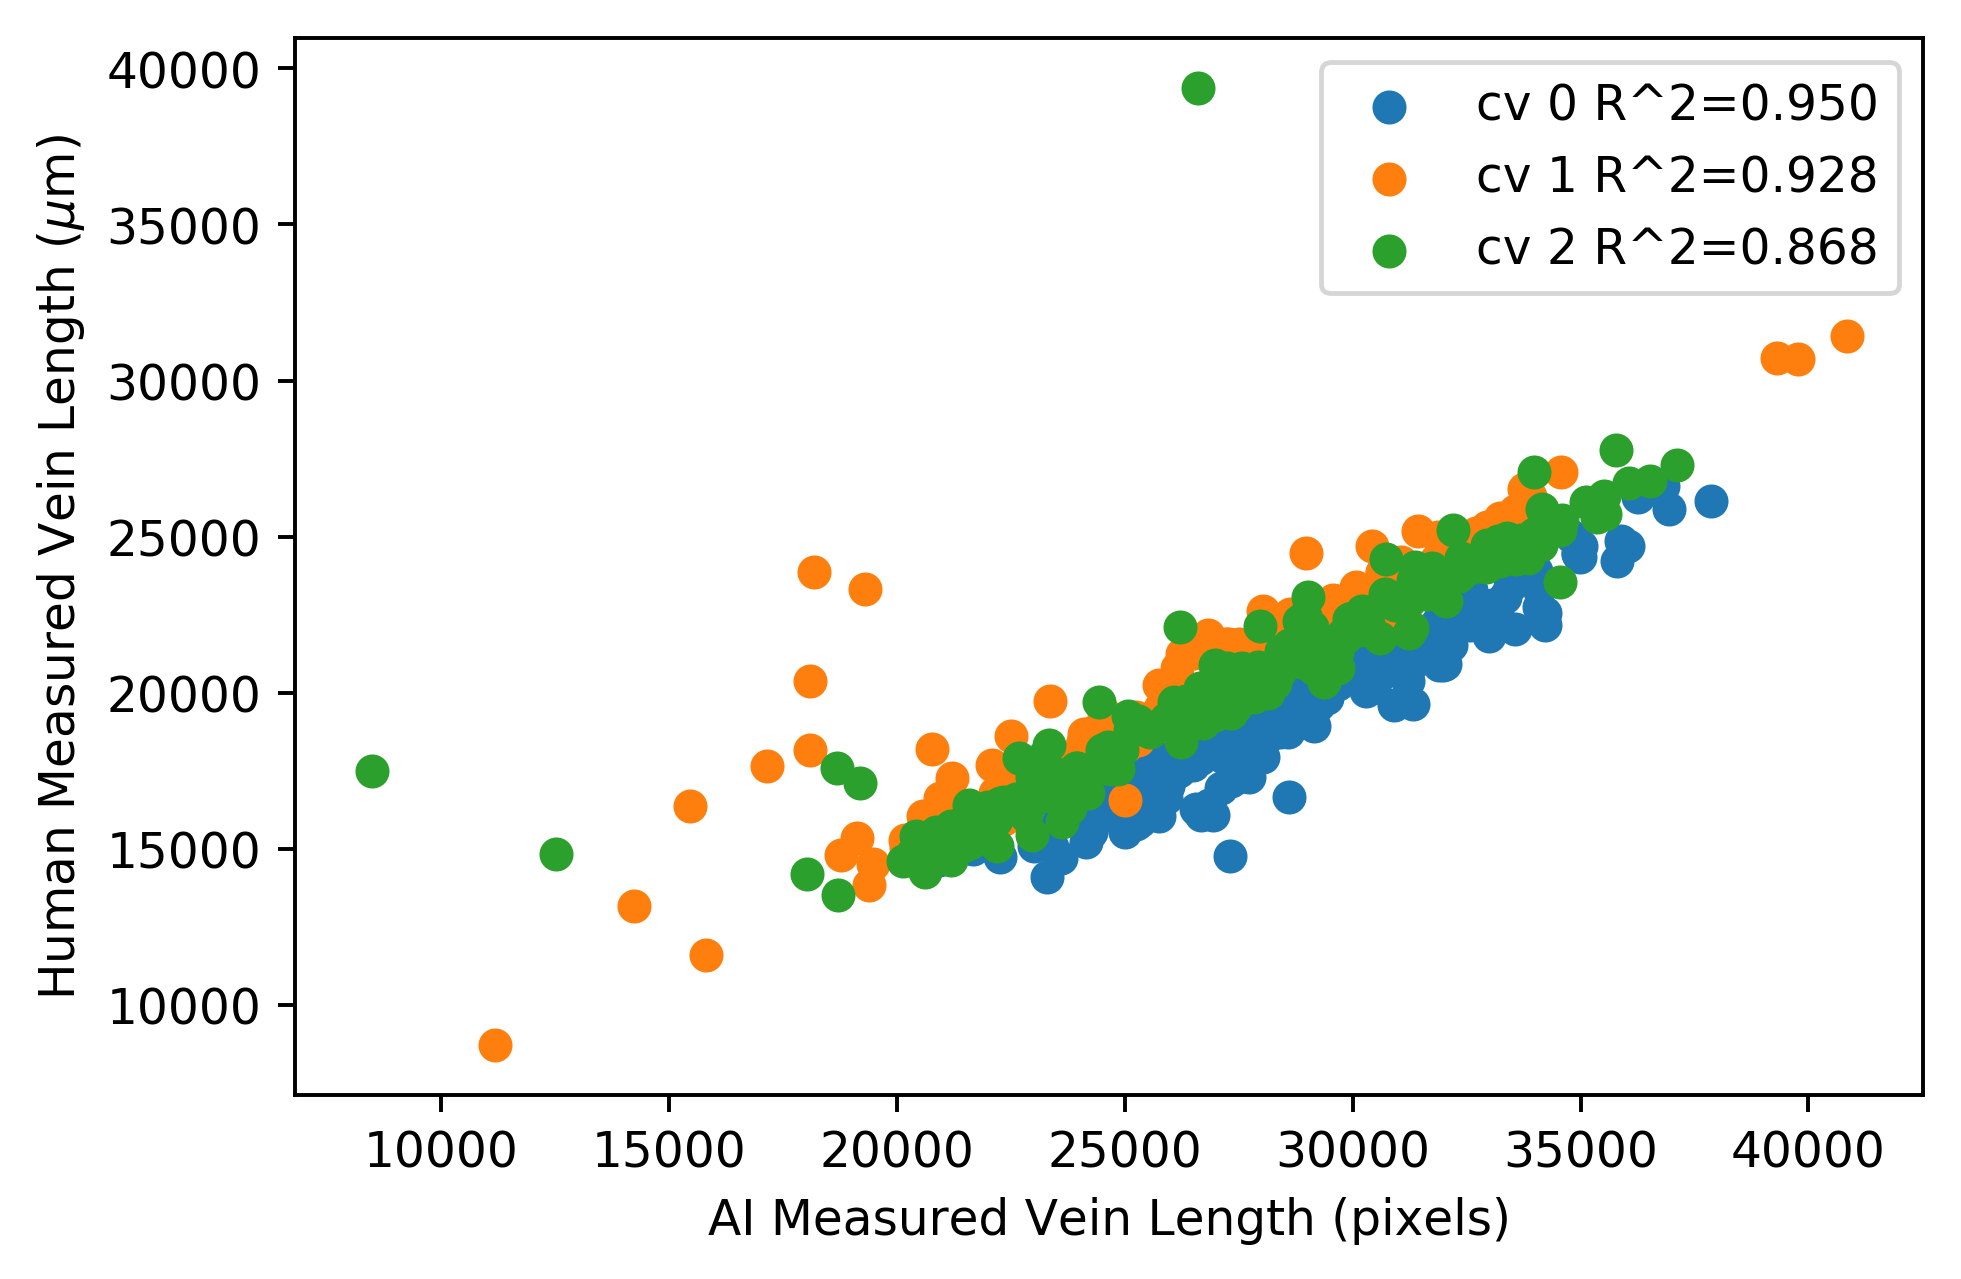

In [6]:
plt.figure(dpi=350)
from scipy.stats.mstats import pearsonr as corr

def plot_scatter(df, label=None):
    if df[['length_measured','length_human']].isna().values.any():
        warnings.warn("NA values detected, they will be dropped")
        df = df.dropna()

    #Plot Scatter data
    plt.scatter(df['length_measured'],df['length_human'],label="%s R^2=%0.3f"%(label, corr(df['length_measured'],df['length_human'])[0]))
    plt.xlabel('AI Measured Vein Length (pixels)')
    plt.ylabel(r'Human Measured Vein Length ($\mu$m)')

for i,cv in enumerate(['0','1','2']):
    threshold = '0.2'
    conn_cv = sqlite3.connect(j(project_root,'data','interm','smoothed_cv' + cv + '_threshold' + threshold + '_lengths.sqlite'))
    df_data = pd.read_sql("SELECT * FROM vein_lengths",conn_cv)

    df_data_merged = df_data.merge(df_human[['plant','replicate','length']],
                           on=["plant","replicate"],
                           how="inner",
                           suffixes=("_measured","_human"),
                           validate="one_to_one")
    
    plot_scatter(df_data_merged,label="cv %s"%(cv))
    plt.legend()

# Cross Validation Training Loss

In [7]:
import re

csv_file = j(project_root,'data','interm','cv_test_loss.csv')

weights = ['01','05','10','20']
Nsteps = 3200

runs = {}
runs['test'] = {}
runs['train'] = {}
for w in weights:
    runs['test'][w] = np.full((3,Nsteps), np.nan, dtype=float)
    runs['train'][w] = np.full((3,Nsteps), np.nan, dtype=float)

with open(csv_file,'r') as fin:
    for line in fin:
        data = line.split(",")
        run = data[0]
        loss_type = data[1]

        if run == "src/models/saved_runs/CV_RUNS/Jul21_17-00-34_gn48.ecomputeCE05_CV0":
            continue
        
        weight = run.split(".")[1].split("_")[0][-2:]
        fold = int(run.split(".")[1].split("_")[1][2])
        values = np.array(data[2:], dtype=float)
        
        n = np.min((len(values),Nsteps))
        runs[loss_type][weight][fold][:n] = values[:n]
    

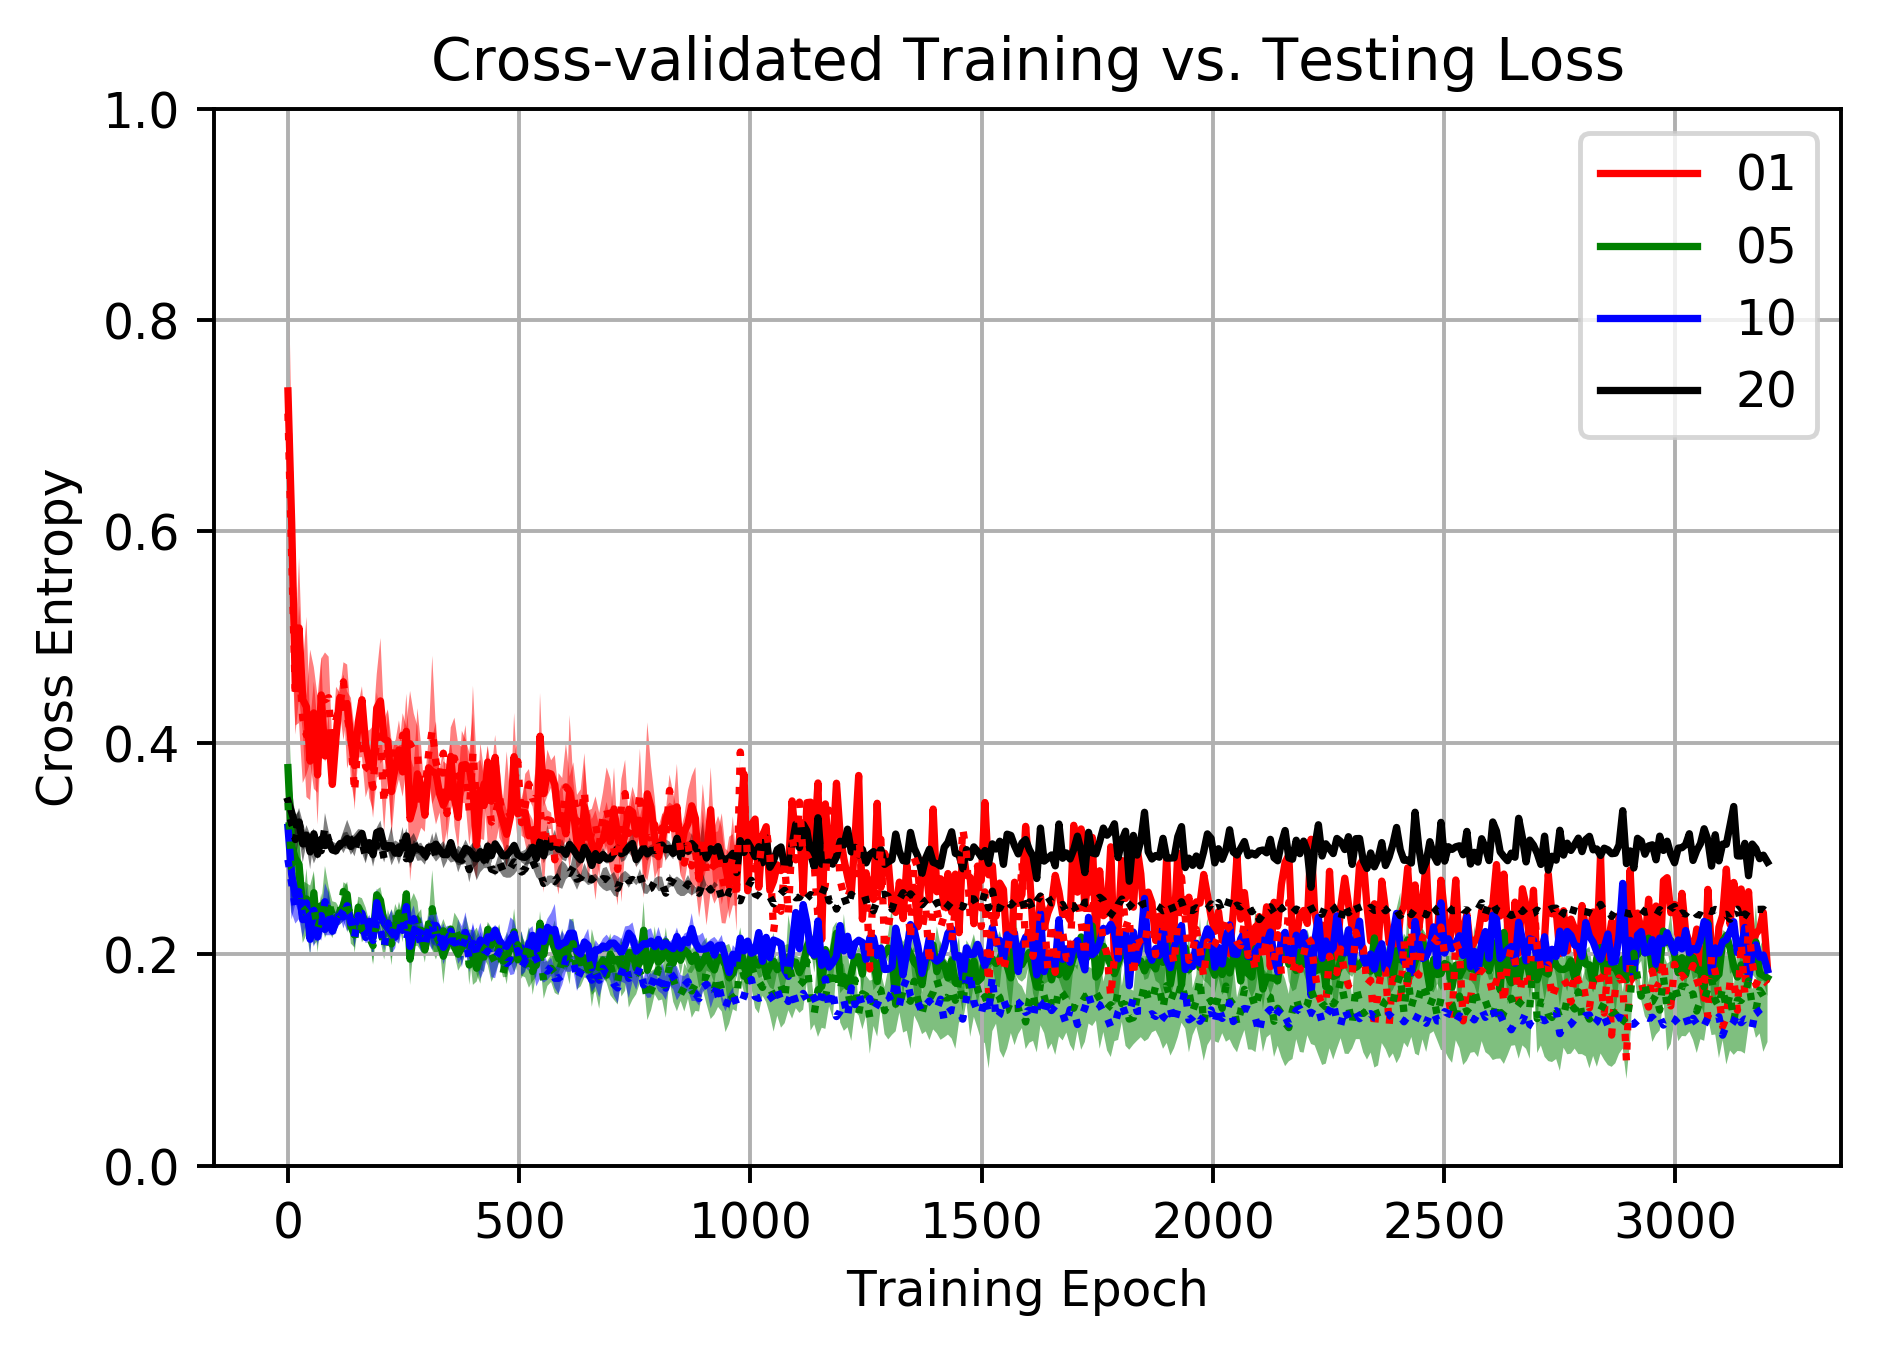

In [8]:
colors = {
    '01': 'r',
    '10': 'b',
    '20': 'k',
    '05': 'g',
}

fig = plt.figure(dpi=350)

## Test data
for key,value in runs['test'].items():
    x = np.arange(Nsteps)
    y = np.nanmean(value,axis=0)
    error = np.nanstd(value,axis=0)
   
    idx = np.linspace(0,len(x)-1,400,dtype=int)
    x = x[idx]
    y = y[idx]
    error = error[idx]
    
    plt.plot(x,y,label=key,c =colors[key])
    plt.fill_between(x, y-error, y+error,
            alpha=0.5, facecolor=colors[key])
    
plt.legend()

# Train data
for key,value in runs['train'].items():
    x = np.arange(Nsteps)
    y = np.nanmean(value,axis=0)
    error = np.nanstd(value,axis=0)
   
    idx = np.linspace(0,len(x)-1,400,dtype=int)
    x = x[idx]
    y = y[idx]
    error = error[idx]
    
    plt.plot(x,y,label=key,c =colors[key], linestyle=":")
    plt.fill_between(x, y-error, y+error,
            alpha=0.5, facecolor=colors[key])
    
plt.ylim((0,1))
plt.title("Cross-validated Training vs. Testing Loss")
plt.ylabel('Cross Entropy')
plt.xlabel('Training Epoch')
plt.grid()
plt.show()

# Final Model Accuracy

In [14]:
conn = sqlite3.connect('../data/processed/final_lengths_validation_smoothed_1900_CE04_T01.sqlite')

df_data = pd.read_sql("SELECT * FROM vein_lengths",conn)
df_human = pd.read_sql("SELECT * FROM manually_measured",conn_man)

def plot_scatter(df):
    if df[['length_measured','length_human']].isna().values.any():
        warnings.warn("NA values detected, they will be dropped")
        df = df.dropna()

    #Plot Scatter data
    plt.scatter(df['length_measured'],df['length_human'])
    plt.xlabel('AI Measured Vein Length (pixels)')
    plt.ylabel(r'Human Measured Vein Length ($\mu$m)')

    #Add correlation information
    r =  df[['length_measured','length_human']].corr()['length_measured'][1]
    plt.text(28000, 17500, r"$r$ = %1.5f"%(r,))
    print(r)

0.9264482139145149


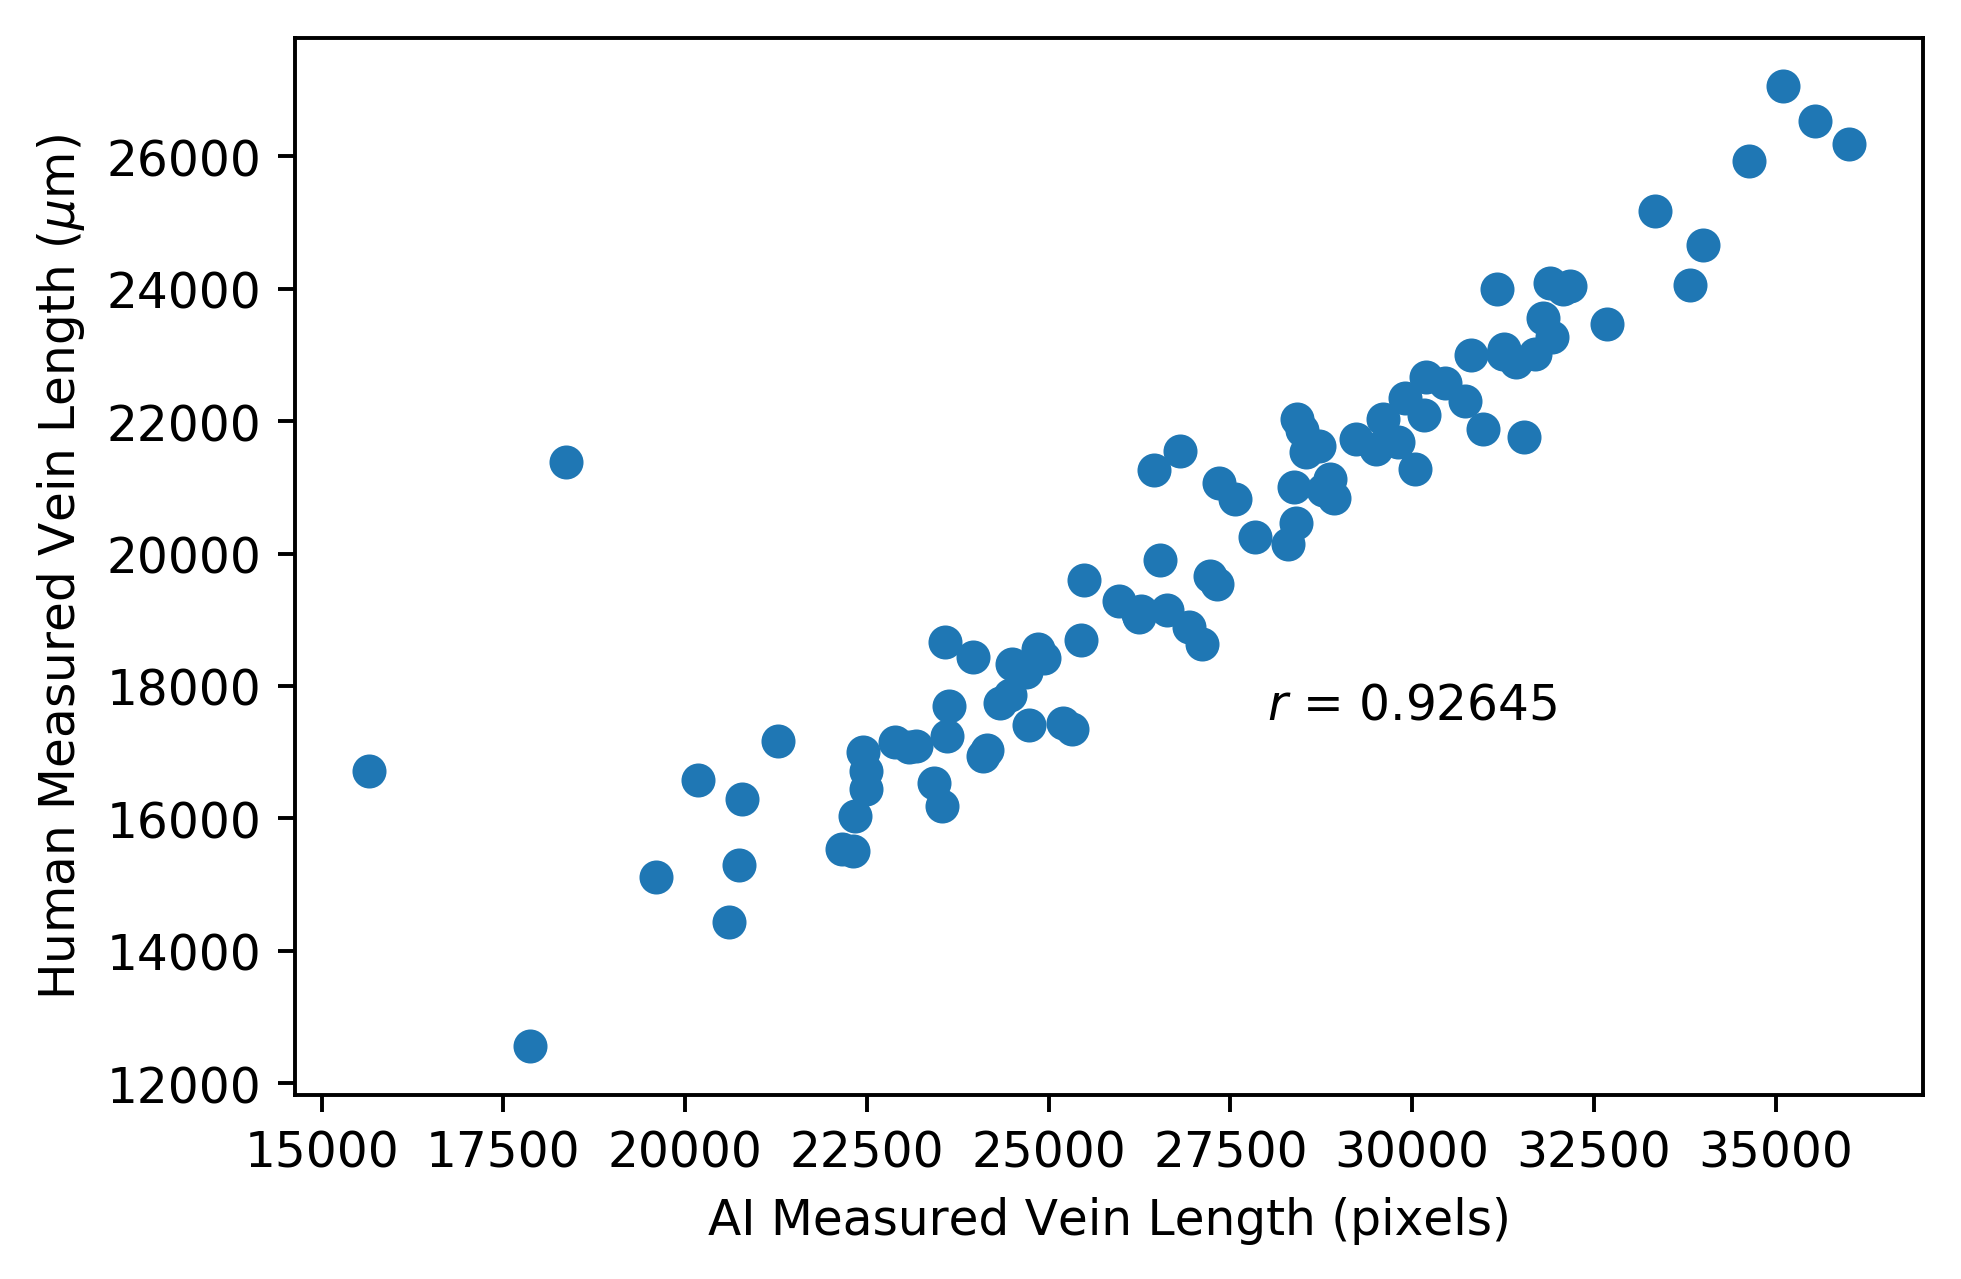

In [15]:
df_data_merged = df_data.merge(df_human[['plant','replicate','length']],
                           on=["plant","replicate"],
                           how="inner",
                           suffixes=("_measured","_human"),
                           validate="one_to_one")
plt.figure(dpi=350)    
plot_scatter(df_data_merged)

Histogram of the errors between the human measured and predicted vein length.

$$ error_i = (x_i-y_i) - \frac{1}{N} \sum_{i=1}^{N} (x_i - y_i) $$

where $x_i$ is the human measured vein length and $y_i$ is the AI measured vein length for sample $i$. 

__Note that the standard deviation and error have no useful units.__ 

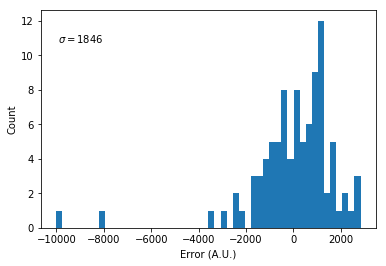

In [16]:
import numpy as np

error = df_data_merged['length_measured'] - df_data_merged['length_human']
error = error - error.mean()

plt.hist(error,50);
plt.xlabel(r'Error (A.U.)')
plt.ylabel('Count')

std = np.std(error)
plt.annotate(r"$\sigma = %0.0f$"%(std,), 
             xy=(0.05, 0.85), 
             xycoords='axes fraction');

## Poorly segmented images

- I defined outliers as measured predictions that were off from the manually measured by more than $3\sigma$ 
- The table naming scheme from the image file names is [plant]-[replicate].jpg

In [17]:
outliers_idx = np.where(error**2 > (std**2 * 3))

print(r"Outliers with an error greater than %0.0f:"%(std * 3,))
outliers = df_data_merged.iloc[outliers_idx].copy()
outliers['error'] = error.iloc[outliers_idx]
outliers[['plant','replicate','length_measured','length_human','error']]

Outliers with an error greater than 5539:


,plant,replicate,length_measured,length_human,error
1,102,8,18355,21384.907,-10008.084548
84,8,3,15656,16718.336,-8040.513548
89,91,6,20172,16572.474,-3378.651548


# Find Accuracy with outliers removed

Recalculate the accuracy with these images removed.

Visual inspection of the outlier images reveals most are incorrectly segmented due to image quality. Removeing these images should be easy to accomplish via manual inspection after segementation. 

The large increase in accuracy suggests that a few badly segmented images affect the overall accuracy to a large extent. 

0.9747690480922868


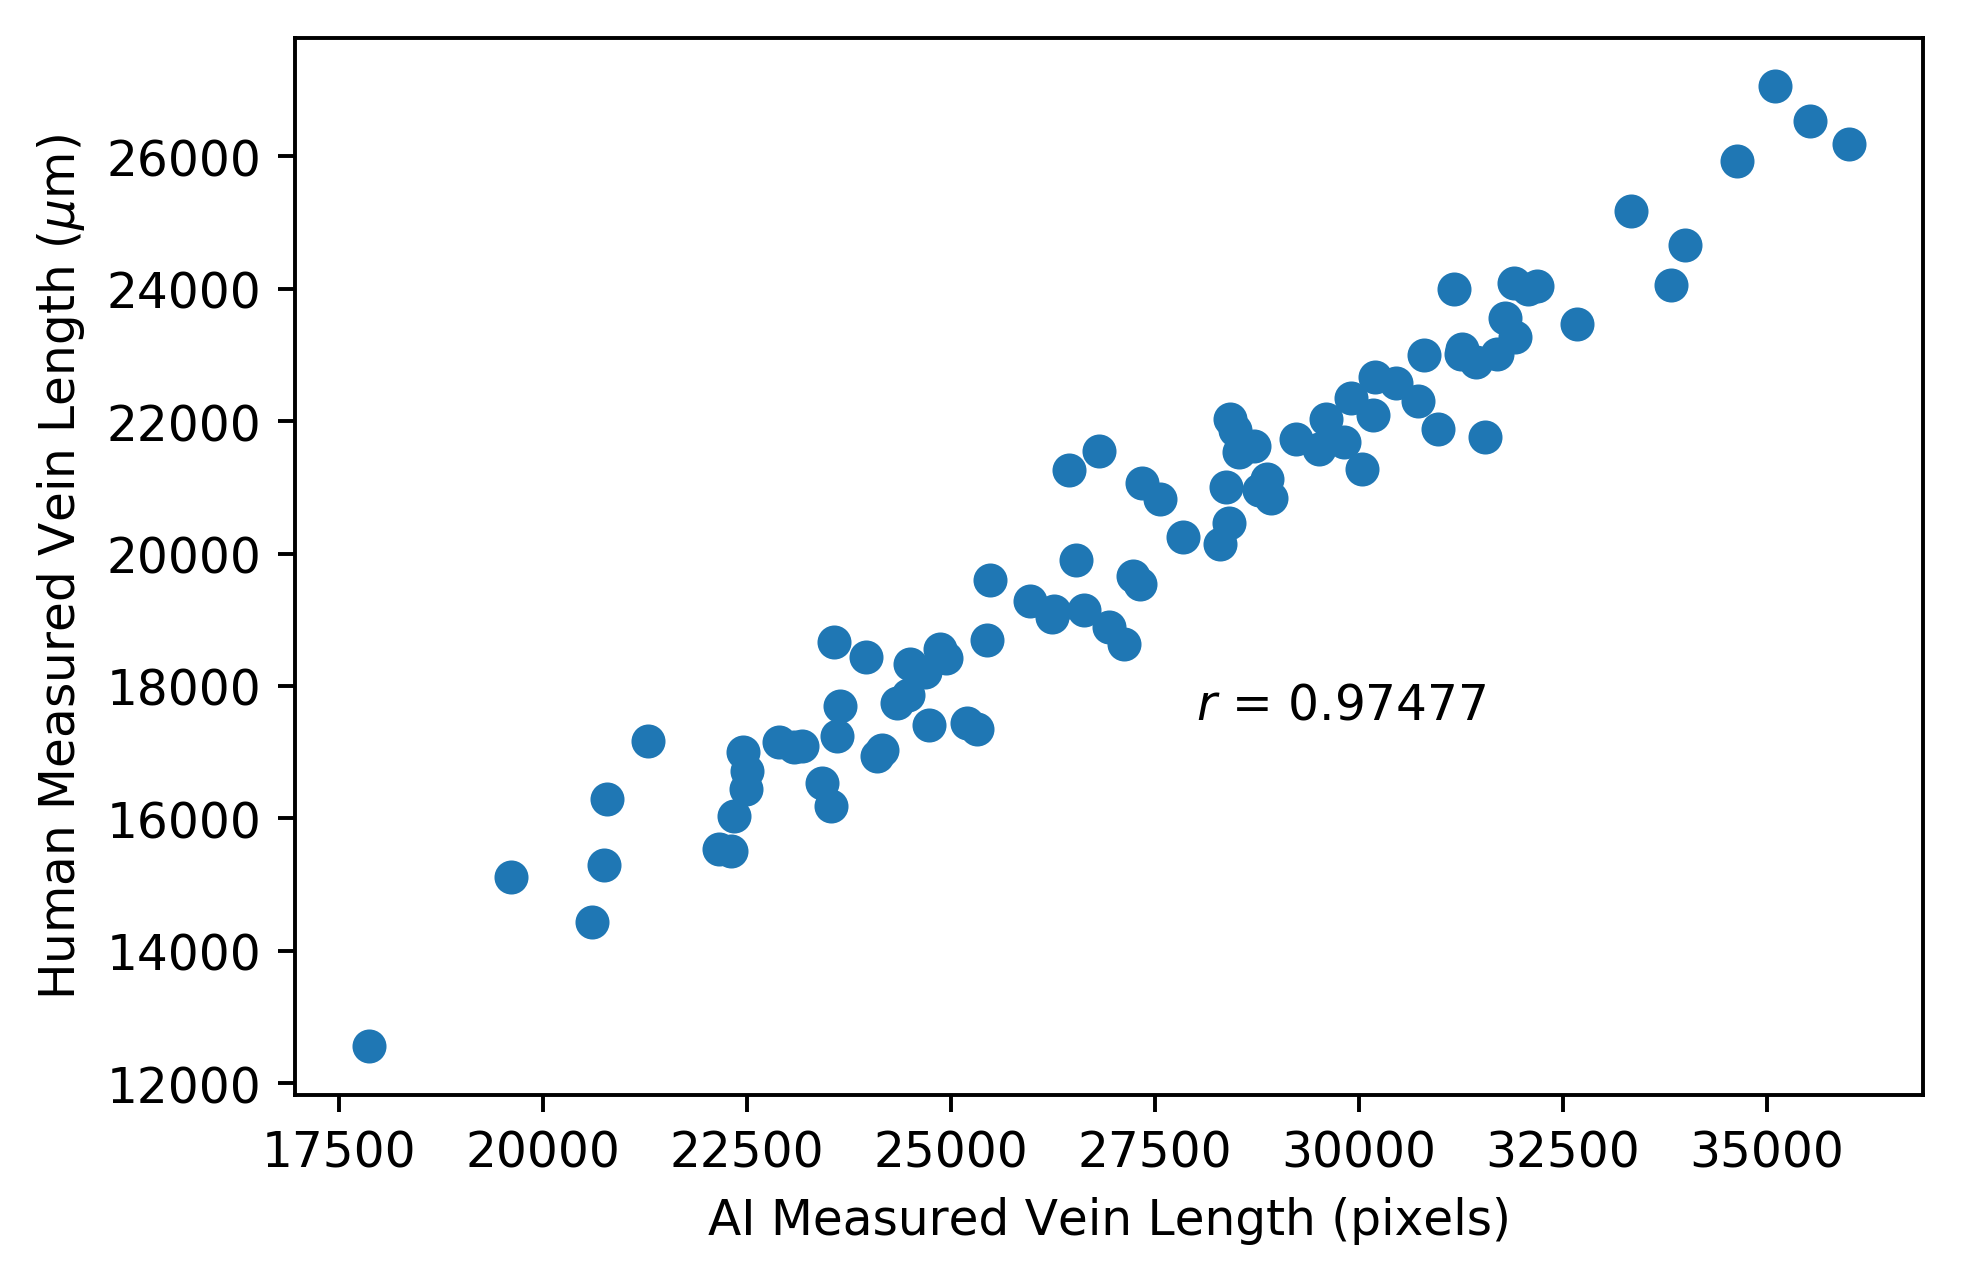

In [18]:
idx = np.where(error**2 <= (std**2 * 3))

plt.figure(dpi=350)    
plot_scatter(df_data_merged.iloc[idx])